In [1]:
%pip install yfinance
%pip install matplotlib
%pip install seaborn
%pip install plotly




Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Import libraries**

In [51]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np


# 1. Concept

## Idea
What are our signals, why this industry, why this stocks...
## Pair Strategy
Add description of our strategy.


# 2. Data

# Retrive data

For each stock we get data from Yahoo Finance based on tickers provided in a list.

## Stock pick

We choose energy sector stocks from *S&P 500* as it is known that they have been highly correlated in the past. We picked 10 stocks with highest market cap in this sector. 

**STOCK LIST:**
- Exxon Mobil Corporation [XOM]
- Chevron Corporation [CVX]
- ConocoPhillips [COP]
- Schlumberger Limited [SLB]
- EOG Resources, Inc. [EOG]
- Marathon Petroleum Corporation [MPC]
- Phillips 66 [PSX]
- Enterprise Products Partners L.P. [EPD]
- Pioneer Natural Resources Company [PXD]
- Occidental Petroleum Corporation [OXY]




## Hourly data
We get data of our stocks as well as S&P 500 index to be able to compare returns of our strategy against a simple benchmark.

In [3]:
# Companies tickers list
ticker_list=['XOM', 'CVX', 'COP' , 'SLB', 'EOG','MPC', 'PSX', 'EPD', 'PXD', 'OXY', '^GSPC']

#get data for last 730 days on hounrly time frame
df_hourly = yf.download(ticker_list, period="730d", interval="1h")['Adj Close']

#rename sp500
df_hourly = df_hourly.rename(columns={'^GSPC':'SP500'})


[*********************100%%**********************]  11 of 11 completed


In [4]:
#check info of our data frame
df_hourly.info()
print(20*'**'+ '\n')

#count NaN values in each column
nan_counts_hourly = df_hourly.isna().sum()
display(nan_counts_hourly)
print(20*'**'+ '\n')

#let's check the index. We want date as index
df_hourly.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2021-04-07 09:30:00-04:00 to 2024-02-29 15:30:00-05:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     5094 non-null   float64
 1   CVX     5094 non-null   float64
 2   EOG     5072 non-null   float64
 3   EPD     5094 non-null   float64
 4   MPC     5094 non-null   float64
 5   OXY     5094 non-null   float64
 6   PSX     5094 non-null   float64
 7   PXD     5094 non-null   float64
 8   SLB     5024 non-null   float64
 9   XOM     5094 non-null   float64
 10  SP500   5094 non-null   float64
dtypes: float64(11)
memory usage: 477.6 KB
****************************************



Ticker
COP       0
CVX       0
EOG      22
EPD       0
MPC       0
OXY       0
PSX       0
PXD       0
SLB      70
XOM       0
SP500     0
dtype: int64

****************************************



DatetimeIndex(['2021-04-07 09:30:00-04:00', '2021-04-07 10:30:00-04:00',
               '2021-04-07 11:30:00-04:00', '2021-04-07 12:30:00-04:00',
               '2021-04-07 13:30:00-04:00', '2021-04-07 14:30:00-04:00',
               '2021-04-07 15:30:00-04:00', '2021-04-08 09:30:00-04:00',
               '2021-04-08 10:30:00-04:00', '2021-04-08 11:30:00-04:00',
               ...
               '2024-02-28 13:30:00-05:00', '2024-02-28 14:30:00-05:00',
               '2024-02-28 15:30:00-05:00', '2024-02-29 09:30:00-05:00',
               '2024-02-29 10:30:00-05:00', '2024-02-29 11:30:00-05:00',
               '2024-02-29 12:30:00-05:00', '2024-02-29 13:30:00-05:00',
               '2024-02-29 14:30:00-05:00', '2024-02-29 15:30:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=5094, freq=None)

For now, we keep data in `wide format`
- each stock is one column
- in all columns, the variable is the same: `adjusted close price`
- row index is date

In [5]:
# lets check what is maximum number of cosencutive NaN values
# If there is only a few we can decide to interpolate data with back ffill or bfill for example to get missing data

def max_consecutive_nan(column):
    max_consecutive = 0
    current_consecutive = 0

    for value in column:
        if pd.isna(value):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 0

    return max_consecutive

# we apply function to each column 
max_nan_values = df_hourly.apply(max_consecutive_nan)
print(max_nan_values)

Ticker
COP      0
CVX      0
EOG      7
EPD      0
MPC      0
OXY      0
PSX      0
PXD      0
SLB      7
XOM      0
SP500    0
dtype: int64


Since there are ***max 7 consecutive NaN values*** we decide to interpolate data instead of dropping the whole series.

In [6]:
#fill missing data with last available data point before the sequence of NaN values
df_filled_hourly = df_hourly.ffill()

#we make sure there is no more missing values in each of our time series (DataFrame)
missing = df_filled_hourly.isna().sum().sum()
print(f'There are {missing} missing values in our DataFrame of hourly prices.')

There are 0 missing values in our DataFrame of hourly prices.


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70 % of dataset will be used for training and remaining 30 % for testing our strategy.

In [7]:
#remove datetime index for slicing needs
df_filled_hourly = df_filled_hourly.reset_index(drop=False)

In [8]:
#split data 70/30

length = len(df_filled_hourly)

#train data is 70% of all available data
df_train_hourly = df_filled_hourly.loc[:int(length*0.7)]
df_train_hourly.to_csv('data/pair_train_h.csv')

#test data is remaining 30% of data
df_test_hourly = df_filled_hourly.loc[int(length*0.7+1):]
df_test_hourly.to_csv('data/pair_test_h.csv')

In [9]:
#check if data is continous without dropped rows (check if index is correct)
display(df_train_hourly.tail(1))
display(df_test_hourly.head())


Ticker                  Datetime         COP         CVX         EOG     EPD  \
3565   2023-04-17 12:30:00-04:00  106.410004  170.970001  121.495003  26.975   

Ticker         MPC        OXY         PSX         PXD    SLB     XOM  \
3565    129.110001  63.200001  104.463699  228.720001  51.82  115.07   

Ticker        SP500  
3565    4131.759766

Ticker                  Datetime         COP         CVX         EOG  \
3566   2023-04-17 13:30:00-04:00  106.019997  170.914993  120.739998   
3567   2023-04-17 14:30:00-04:00  106.004997  171.240005  121.070000   
3568   2023-04-17 15:30:00-04:00  105.610001  170.919998  120.800003   
3569   2023-04-18 09:30:00-04:00  105.330002  170.964996  119.779999   
3570   2023-04-18 10:30:00-04:00  105.135002  171.160004  119.055000   

Ticker        EPD         MPC        OXY         PSX         PXD        SLB  \
3566    26.895000  129.059998  63.009998  103.989998  228.630005  51.715000   
3567    26.955000  129.649994  63.200001  104.400002  229.399994  51.959999   
3568    26.924999  129.360001  62.939999  103.940002  228.270004  52.070000   
3569    27.059999  128.679993  62.685001  104.250000  227.759995  52.270000   
3570    27.033800  128.490005  62.639999  104.230003  227.221802  52.150002   

Ticker         XOM        SP500  
3566    114.739998  4128.490234  
3567    114.904999  4147.140137  
3568    114.720001  4151.399902  
3569    115.099998  4147.060059  
3570    115.449997  4146.910156

# Daily data

In [10]:
# Set analyzed period
start_date="2000-01-01"
end_date="2023-12-31"

#get data from yahoo finance
df_daily = yf.download(ticker_list, start=start_date, end=end_date, interval="1d")['Adj Close']

#rename sp500
df_daily = df_daily.rename(columns={'^GSPC':'SP500'})

[*********************100%%**********************]  11 of 11 completed


In [11]:
#explore dataframe
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2000-01-03 to 2023-12-29
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     6037 non-null   float64
 1   CVX     6037 non-null   float64
 2   EOG     6037 non-null   float64
 3   EPD     6037 non-null   float64
 4   MPC     3150 non-null   float64
 5   OXY     6037 non-null   float64
 6   PSX     2949 non-null   float64
 7   PXD     6037 non-null   float64
 8   SLB     6037 non-null   float64
 9   XOM     6037 non-null   float64
 10  SP500   6037 non-null   float64
dtypes: float64(11)
memory usage: 566.0 KB


In [12]:
# Count NaN values in each column
nan_counts = df_daily.isna().sum()

# Display the result
print(nan_counts)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [13]:
# we apply function to each column 
max_nan_values_daily = df_daily.apply(max_consecutive_nan)
print(max_nan_values_daily)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [14]:
#Drop columns of MPC and PSX

df_daily_filtered = df_daily.drop(columns=['MPC', 'PSX'])

#reset index
df_daily_filtered=df_daily_filtered.reset_index(drop=False)


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70 % of dataset will be used for training and remaining 30 % for testing our strategy.

In [15]:
#split data 70/30

length = len(df_daily_filtered)

#train data is 70% of all available data
df_train_daily = df_daily_filtered.loc[:int(length*0.7)]
df_train_daily.to_csv('data/pair_train_daily.csv')

#test data is remaining 30% of data
df_test_daily = df_daily_filtered.loc[int(length*0.7+1):]
df_test_daily.to_csv('data/pair_test_daily.csv')

# 3. EDA

## Hourly EDA

In [16]:
# load csv of train data
df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)

#set index to date column
df_train_h.set_index('Datetime', inplace=True)

df_train_h.head()

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_30007/112882630.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)


COP         CVX        EOG        EPD  \
Datetime                                                                 
2021-04-07 09:30:00-04:00  52.509998  104.160004  73.029999  22.690001   
2021-04-07 10:30:00-04:00  52.480000  104.239998  73.059998  22.665001   
2021-04-07 11:30:00-04:00  52.389999  103.720001  72.639999  22.614799   
2021-04-07 12:30:00-04:00  52.529999  104.370003  73.279999  22.680000   
2021-04-07 13:30:00-04:00  52.345001  104.239998  73.339996  22.628099   

                                 MPC        OXY        PSX         PXD  \
Datetime                                                                 
2021-04-07 09:30:00-04:00  53.810001  25.410000  79.489998  152.750000   
2021-04-07 10:30:00-04:00  53.810001  25.250000  79.739998  153.080002   
2021-04-07 11:30:00-04:00  53.470001  25.150000  79.239998  152.750000   
2021-04-07 12:30:00-04:00  53.985001  25.465099  80.139999  153.904999   
2021-04-07 13:30:00-04:00  53.904999  25.370001  80.030098  154.199997   

                                 SLB        XOM        SP500  
Datetime                                                      
2021-04-07 09:30:00-04:00  27.570000  56.584999  4081.659912  
2021-04-07 10:30:00-04:00  27.360001  56.580002  4076.010010  
2021-04-07 11:30:00-04:00  27.230000  56.389999  4069.050049  
2021-04-07 12:30:00-04:00  27.510000  56.700001  4073.919922  
2021-04-07 13:30:00-04:00  27.410000  56.586102  4079.689941

In [17]:
fig = px.line(df_train_h, x=df_train_h.index, y=df_train_h.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig.update_layout(title='Adjusted Hourly Close Prices of Selected Stocks And S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

#show plot
fig.show()

In [39]:
#make long format for pct_change calculation
df_long_h = pd.melt(df_train_h.reset_index(), id_vars=['Datetime'], var_name='ticker', value_name='price')

#set index again
df_long_h.set_index('Datetime', inplace=True)

#calculate pct change for each ticker
df_long_h['ret'] = df_long_h.groupby('ticker')['price'].pct_change()
df_long_h.dropna(inplace=True)


In [54]:
#calculate cumulative return
#df_long_h = df_long_h.sort_values(['Datetime', 'ticker'])
df_long_h['cum_ret'] = df_long_h.groupby('ticker')['ret'].transform(lambda x: np.cumprod(1 + x))

In [55]:
# Assuming df_long_h is your DataFrame with 'Datetime', 'ticker', and 'cumulative_return' columns
fig = px.line(df_long_h, x=df_long_h.index, y='cum_ret', color='ticker',
              title='Cumulative Returns of Selected Stocks',
              labels={'cum_ret': 'Cumulative Return', 'ticker': 'Ticker'},
              line_shape='linear')

fig.update_layout(xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()


### Correlation test

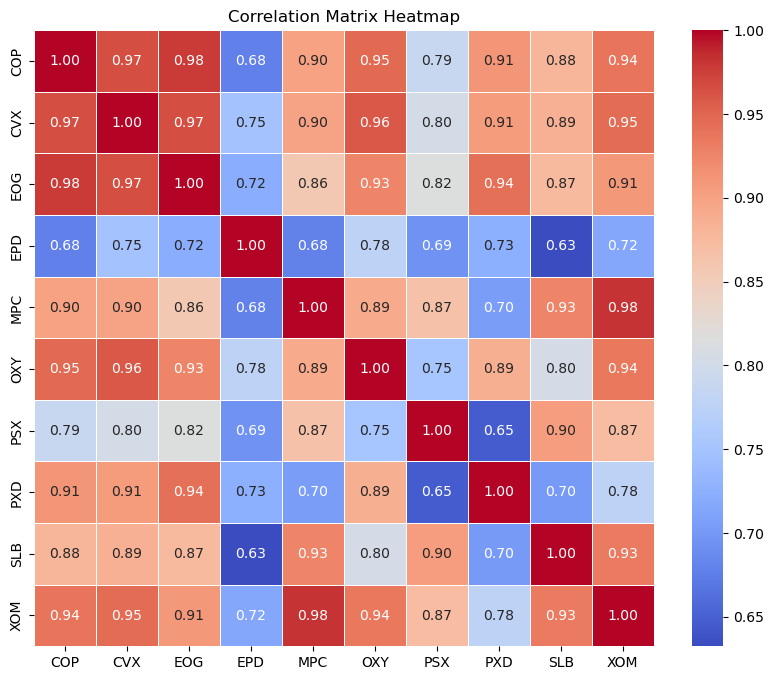

In [140]:
#drop SP500 column for statistical tests
df_train_h_stat = df_train_h.drop(columns='SP500')

corr_matrix_hourly = df_train_h_stat.corr()

# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Cointegration test

## Daily EDA

In [133]:
# load csv of train data
df_train_d = pd.read_csv('data/pair_train_daily.csv', index_col=0, parse_dates=True)

#set index to date column
df_train_d.set_index('Date', inplace=True)

df_train_d.head()


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_11067/506303630.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



COP        CVX       EOG       EPD       OXY       PXD  \
Date                                                                      
2000-01-03  7.988743  17.139816  2.775415  0.937857  5.084859  6.370454   
2000-01-04  7.834474  17.139816  2.775415  0.956998  4.977971  6.464832   
2000-01-05  7.691231  17.447252  2.697077  0.969758  5.008514  6.276078   
2000-01-06  7.955686  18.190231  2.920900  0.956998  5.145942  6.417643   
2000-01-07  7.955686  18.510483  2.887327  0.941048  5.298640  6.606398   

                  SLB        XOM        SP500  
Date                                           
2000-01-03  17.465258  18.328690  1455.219971  
2000-01-04  17.226831  17.977634  1399.420044  
2000-01-05  17.187080  18.957699  1402.109985  
2000-01-06  18.359381  19.937761  1403.449951  
2000-01-07  18.697163  19.879242  1441.469971

In [134]:
fig1 = px.line(df_train_d, x=df_train_d.index, y=df_train_d.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig1.update_layout(title='Adjusted Daily Close Prices of Selected Stocks and S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

# Show the interactive plot
fig1.show()

### Correlation test

In [135]:
#make a copy of dataframe without column SP500 for statistical tests
df_train_d_stat = df_train_d.drop(columns='SP500')

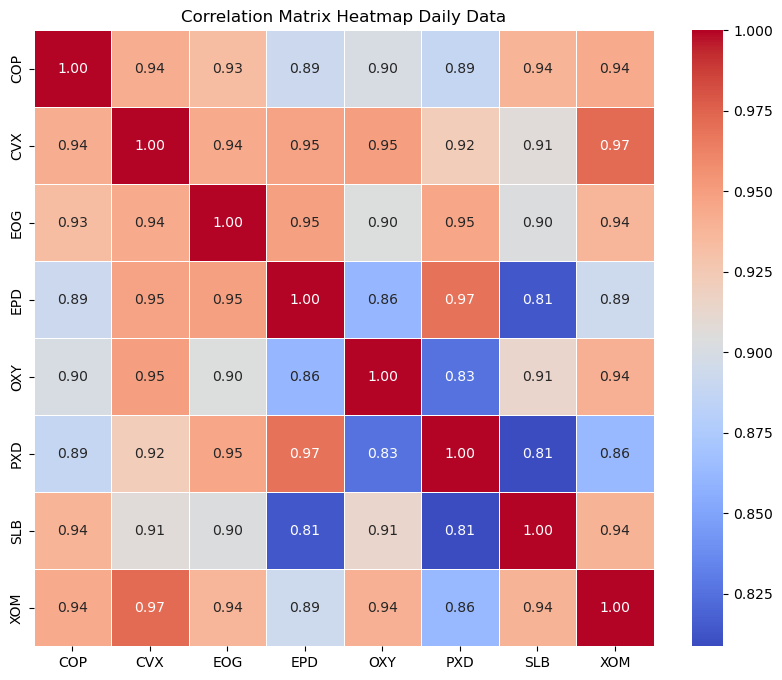

In [136]:
corr_matrix_daily = df_train_d_stat.corr()

# plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_daily, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap Daily Data')
plt.show()

### Cointegration test